In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import ns
import history_cmc as hic
import math
import scipy
from scipy import stats
from scipy.optimize import bisect
from scipy import integrate
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import scripts
import scripts1
import scripts2
import scripts3
import dynamics as dyn
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import os, sys
import gzip
from scipy.interpolate import interp1d
from scipy.stats import lognorm
from scipy.stats import maxwell
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 24})
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times New Roman'
#plt.rc('font', family='serif')
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**(-3) ##pc*M_sun**-1*(km/s)2
Gconst_mkgs = 6.6743*10**(-11) ##m^3 kg^-1 s^-2
clight=3*10**10 ##cm/s
clight_km=3*10**5 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun
PC_AU = 206265 ##pc to AU

Gconst_pc = Gconst_sun/(PC/10.**5)**2

savepath = '/projects/b1095/syr904/projects/BHbinares_catalog/'

2.1.2


In [2]:
sourcedir = np.genfromtxt('/projects/b1095/syr904/projects/BHbinares_catalog/path_allfinished_newruns_maingrid.dat',
                         dtype=str)
paths = sourcedir[:,0]; status = sourcedir[:,1].astype(np.int)
paths = paths[status==1]
#paths = paths[:144]

In [ ]:
t_step = [0.2,0.5,1.,10.]  #Gyr
Ninit = [8e5, 16e5]#, 1.6e6]


for zz in range(len(Ninit)):
    #fbbh = open(savepath+'BBH_'+str(Ninit[zz])+'.dat', 'w+')
    #fbbh.write('#1.Nstar 2.Rv[pc] 3.Zmetal 4.Rg[kpc] 5.Time[Myr] 6.M0[Msun] 7.M1[Msun] 8.SMA[AU] 9.ECC\n')
    
    #fig1, ax1 = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=True, figsize=(16, 16))
    #fig2, ax2 = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=True, figsize=(16, 24))
    for hh in range(len(t_step)):
        bhm0 = [[],[],[],[]]; bhm1 = [[],[],[],[]]
        bhsma = [[],[],[],[]]; bhecc = [[],[],[],[]]
        for xx in range(len(paths)):
            t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
            
            s=paths[xx].split('/')
            n_star=int(float(s[-2]))
            z=float(s[-3][1:])
            rg=float(s[-4][2:])
            rv=float(s[-5][2:])
            
            allsnaps=np.sort(glob(paths[xx]+'*.snap*.dat.gz'))
            snap2d=np.sort(glob(paths[xx]+'*.snap*.2Dproj.dat.gz'))
    
            index=[]
            for mm in range(len(allsnaps)):
                for nn in range(len(snap2d)):
                    if allsnaps[mm]==snap2d[nn]: index.append(mm)
    
            allsnaps = [x for y, x in enumerate(allsnaps) if y not in index]
            
            print(allsnaps)
            if n_star!=Ninit[zz] or z>0.002:
                continue
            
            #print(paths[xx])
            for ii in range(len(allsnaps)):
                if os.stat(allsnaps[ii]).st_size==0:
                        continue
                if ns.get_time(allsnaps[ii])*t_conv>=t_step[hh]*1000.:
                    print(ns.get_time(allsnaps[ii])*t_conv, paths[xx])
                    thetime = ns.get_time(allsnaps[ii])*t_conv
                    with gzip.open(allsnaps[ii], 'r') as fsnap:
                        next(fsnap); next(fsnap)
                        for line in fsnap:
                            data=line.split()
                            if int(data[7])==1 and int(data[17])==14 and int(data[18])==14:
                                bhm0[int(math.log2(rv/0.5))].append(float(data[8]))
                                bhm1[int(math.log2(rv/0.5))].append(float(data[9]))
                                bhsma[int(math.log2(rv/0.5))].append(float(data[12]))
                                bhecc[int(math.log2(rv/0.5))].append(float(data[13]))
                                
                                
                                ##1.Nstar 2.Rv[pc] 3.Zmetal 4.Rg[kpc] 5.Time[Myr] 6.M0[Msun] 7.M1[Msun] 8.SMA[AU] 9.ECC      
                                #fbbh.write('%.1e %f %f %d %.2f %.2f %.2f %.2f %.2f\n'
                                #           %(n_star,rv,z,rg,thetime,
                                #             float(data[8]),float(data[9]),float(data[12]),float(data[13])))
                                        
                    break
            
        for jj in range(4):
            print(len(bhsma[jj]))
            Eb = np.array(Gconst_sun*np.array(bhm0[jj])*np.array(bhm1[jj])/2./(np.array(bhsma[jj])/PC_AU)*
                         (Msun/1000.)*1.e6)
            #ax1[jj][hh].hist(bhsma[jj],
            #                 bins = np.logspace(np.log10(np.min(bhsma[jj])), 
            #                                    np.log10(np.max(bhsma[jj])),int(len(bhsma[jj])/5.)),
            #                histtype='step', lw=3, alpha=0.8)
            binno = 8#int(len(Eb)/5.)
            #ax1[jj][hh].hist(Eb,
            #                 bins = np.logspace(np.log10(np.min(Eb)), 
            #                                    np.log10(np.max(Eb)),binno),
            #                histtype='step', lw=3, alpha=0.8)
            #ax1[jj][hh].set_xscale('log')
            #if jj==3:
            #    ax1[jj][hh].set_xlabel(r'$E_b\,(\rm{J})$')
            #if jj==0:
            #    ax1[jj][hh].set_title(str(t_step[hh])+' Gyr')
        
    #plt.subplots_adjust(wspace=0.02, hspace=0.05)
    #fig1.tight_layout()
    
    #fbbh.close()

['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0000.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0001.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0002.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0003.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0004.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0005.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0006.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0007.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0008.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0009.dat.gz', '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/initial.snap0010.dat.gz'

In [3]:
##Present-day BBH properties
t_step = [12.5, 13.]  #Gyr9., 9.5, 10., 10.5, 11., 11.5, 12., 
Ninit = [16e5]#, 1.6e6]


for zz in range(len(Ninit)):
    fbbh = open(savepath+'BBH_'+str(Ninit[zz])+'.dat', 'a+')
    fbbh.write('#1.Nstar 2.Rv[pc] 3.Zmetal 4.Rg[kpc] 5.Time[Myr] 6.M0[Msun] 7.M1[Msun] 8.SMA[AU] 9.ECC\n')
    
    #fig1, ax1 = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=True, figsize=(16, 16))
    #fig2, ax2 = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=True, figsize=(16, 24))
    for hh in range(len(t_step)):
        bhm0 = [[],[],[],[]]; bhm1 = [[],[],[],[]]
        bhsma = [[],[],[],[]]; bhecc = [[],[],[],[]]
        for xx in range(len(paths)):
            t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
            
            s=paths[xx].split('/')
            n_star=int(float(s[-2]))
            z=float(s[-3][1:])
            rg=float(s[-4][2:])
            rv=float(s[-5][2:])
            
            allsnaps=np.sort(glob(paths[xx]+'*.snap*.dat.gz'))
            snap2d=np.sort(glob(paths[xx]+'*.snap*.2Dproj.dat.gz'))
    
            index=[]
            for mm in range(len(allsnaps)):
                for nn in range(len(snap2d)):
                    if allsnaps[mm]==snap2d[nn]: index.append(mm)
    
            allsnaps = [x for y, x in enumerate(allsnaps) if y not in index]
            
            if n_star!=Ninit[zz]:# or z>0.002:
                continue
            
            #print(paths[xx])
            for ii in range(len(allsnaps)):
                if os.stat(allsnaps[ii]).st_size==0:
                        continue
                if ns.get_time(allsnaps[ii])*t_conv>=t_step[hh]*1000.:
                    print(ns.get_time(allsnaps[ii])*t_conv, paths[xx])
                    thetime = ns.get_time(allsnaps[ii])*t_conv
                    with gzip.open(allsnaps[ii], 'r') as fsnap:
                        next(fsnap); next(fsnap)
                        for line in fsnap:
                            data=line.split()
                            if int(data[7])==1 and int(data[17])==14 and int(data[18])==14:
                                #bhm0[int(math.log2(rv/0.5))].append(float(data[8]))
                                #bhm1[int(math.log2(rv/0.5))].append(float(data[9]))
                                #bhsma[int(math.log2(rv/0.5))].append(float(data[12]))
                                #bhecc[int(math.log2(rv/0.5))].append(float(data[13]))
                                
                                
                                ##1.Nstar 2.Rv[pc] 3.Zmetal 4.Rg[kpc] 5.Time[Myr] 6.M0[Msun] 7.M1[Msun] 8.SMA[AU] 9.ECC      
                                fbbh.write('%.1e %f %f %d %.2f %.2f %.2f %.2f %.2f\n'
                                           %(n_star,rv,z,rg,thetime,
                                             float(data[8]),float(data[9]),float(data[12]),float(data[13])))
                                        
                    break
            
        #for jj in range(4):
        #    print(len(bhsma[jj]))
        #    Eb = np.array(Gconst_sun*np.array(bhm0[jj])*np.array(bhm1[jj])/2./(np.array(bhsma[jj])/PC_AU)*
        #                 (Msun/1000.)*1.e6)
        #    #ax1[jj][hh].hist(bhsma[jj],
        #    #                 bins = np.logspace(np.log10(np.min(bhsma[jj])), 
        #    #                                    np.log10(np.max(bhsma[jj])),int(len(bhsma[jj])/5.)),
        #    #                histtype='step', lw=3, alpha=0.8)
        #    binno = 8#int(len(Eb)/5.)
        #    #ax1[jj][hh].hist(Eb,
        #    #                 bins = np.logspace(np.log10(np.min(Eb)), 
        #    #                                    np.log10(np.max(Eb)),binno),
        #    #                histtype='step', lw=3, alpha=0.8)
        #    #ax1[jj][hh].set_xscale('log')
        #    #if jj==3:
        #    #    ax1[jj][hh].set_xlabel(r'$E_b\,(\rm{J})$')
        #    #if jj==0:
        #    #    ax1[jj][hh].set_title(str(t_step[hh])+' Gyr')
        
    #plt.subplots_adjust(wspace=0.02, hspace=0.05)
    #fig1.tight_layout()
    
    fbbh.close()

12603.760494408 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.002/1.6e6/
12594.615938399998 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.02/1.6e6/
12603.76580124 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.002/1.6e6/
12592.027973328 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.02/1.6e6/
12522.029974776 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.002/1.6e6/
12570.132868968 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.02/1.6e6/
12508.305253485998 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg2/z0.0002/1.6e6/
12508.312007968 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg2/z0.002/1.6e6/
12508.300250166 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg2/z0.02/1.6e6/
12508.314759793999 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.0002/1.6e6/
12508.303252157999 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.002/1.6e6/
12508.349032536 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.02/1.6e6/
12503.225132524 /p

/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.002/8e5/
1 3 5 0.1111111111111111
/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.002/8e5/
1 5 44 0.02
/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.002/8e5/
5 15 65 0.058823529411764705
/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg2/z0.002/8e5/
11 24 247 0.03900709219858156
/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.002/8e5/
17 22 291 0.051515151515151514
/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg20/z0.002/8e5/
18 31 407 0.039473684210526314
/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg2/z0.002/8e5/
22 26 965 0.02171767028627838
/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg8/z0.002/8e5/
26 22 1128 0.022108843537414966
/projects/b1091/CMC_Grid_March2019/rundir/rv2/rg20/z0.002/8e5/
33 20 1368 0.02322308233638283
/projects/b1091/CMC_Grid_March2019/rundir/rv4/rg8/z0.002/8e5/
30 23 2901 0.010155721056194989
/projects/b1091/CMC_Grid_March2019/rundir/rv4/rg20/z0.002/8e5/
34 33 2992 0.011114743380

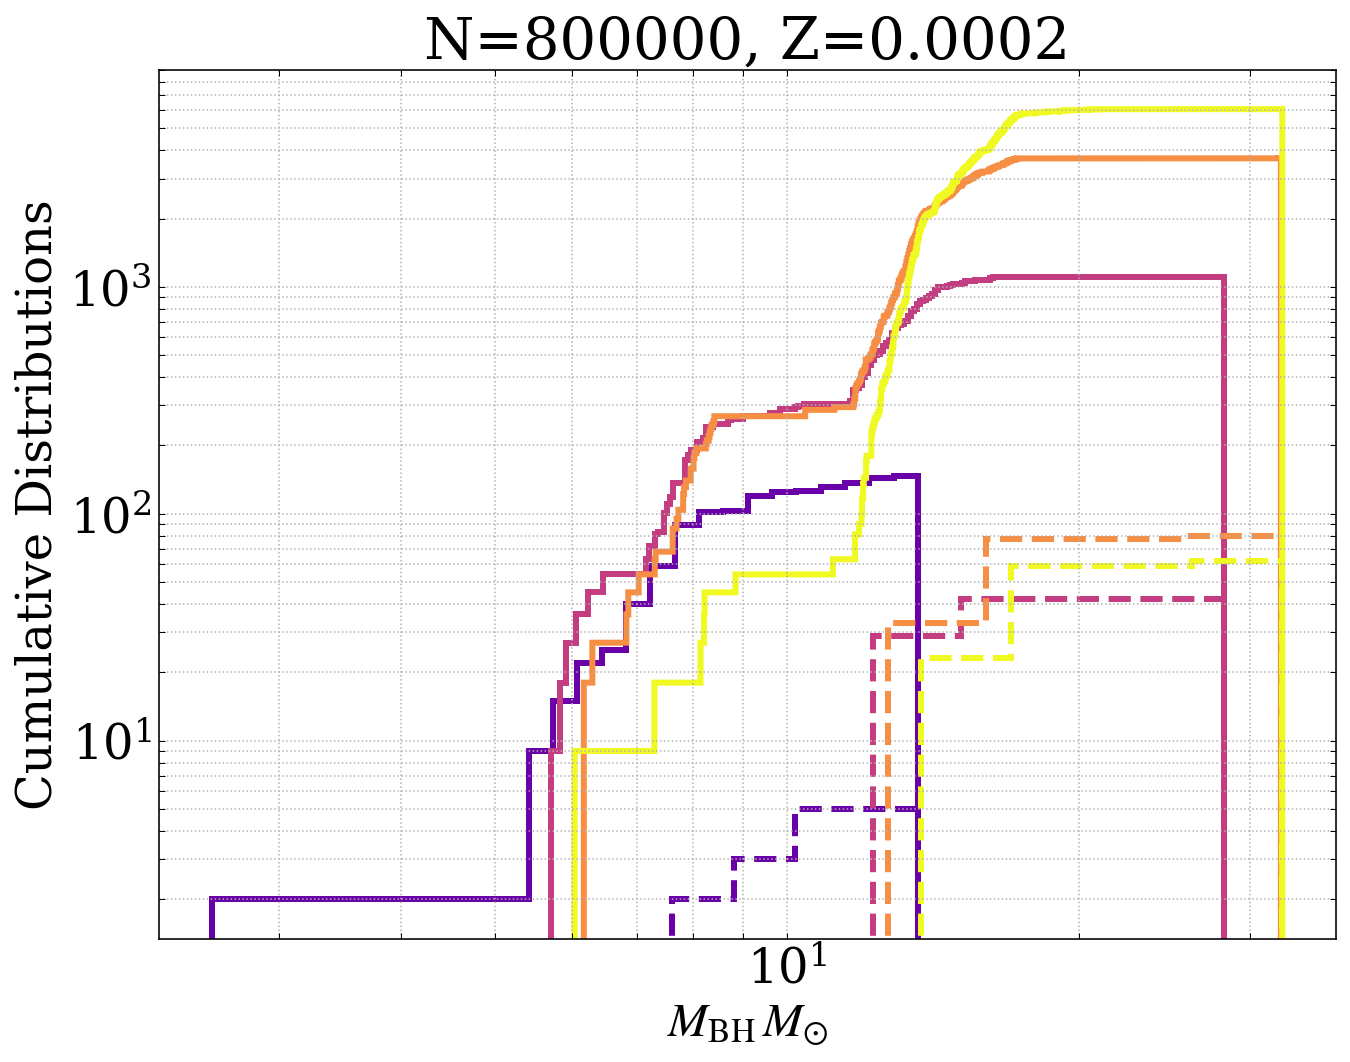

In [4]:
##Present-day BBH binary fraction
t_step = [9., 9.5, 10., 10.5, 11., 11.5, 12., 12.5, 13.]  #Gyr
Ninit = [8e5]

cs = cm.plasma(np.linspace(0.2, 1, 4))
#cmap=matplotlib.colors.ListedColormap([c[0], c[1], c[2], c[3]])

for zz in range(len(Ninit)):
    fbbh = open(savepath+'BBH_fraction_'+str(Ninit[zz])+'_0.002.dat', 'w+')
    fbbh.write('#1.Nstar 2.Rv[pc] 3.Zmetal 4.Rg[kpc] 5.Nbbh 6.Nbhb 7.Nbhs 8.bbh_frac\n')
    fbbh.write('#for 9 snapshots\n')
    
    bhm0 = [[],[],[],[]]; bhm1 = [[],[],[],[]]
    bhm = [[],[],[],[]]
    bhb = [[],[],[],[]]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    for xx in range(len(paths)):
        nbbh = 0; nbhb = 0; nbhs = 0
        
        t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
            
        s=paths[xx].split('/')
        n_star=int(float(s[-2]))
        z=float(s[-3][1:])
        rg=float(s[-4][2:])
        rv=float(s[-5][2:])
        
        if n_star!=Ninit[zz] or z!=0.002:
            continue
            
        allsnaps=np.sort(glob(paths[xx]+'*.snap*.dat.gz'))
        snap2d=np.sort(glob(paths[xx]+'*.snap*.2Dproj.dat.gz'))
    
        index=[]
        for mm in range(len(allsnaps)):
            for nn in range(len(snap2d)):
                if allsnaps[mm]==snap2d[nn]: index.append(mm)
    
        allsnaps = [x for y, x in enumerate(allsnaps) if y not in index]
        
        for hh in range(len(t_step)):
            for ii in range(len(allsnaps)):
                if os.stat(allsnaps[ii]).st_size==0:
                        continue
                if ns.get_time(allsnaps[ii])*t_conv>=t_step[hh]*1000.:
                    #print(ns.get_time(allsnaps[ii])*t_conv, paths[xx])
                    thetime = ns.get_time(allsnaps[ii])*t_conv
                    with gzip.open(allsnaps[ii], 'r') as fsnap:
                        next(fsnap); next(fsnap)
                        for line in fsnap:
                            data=line.split()
                            if int(data[7])==1 and int(data[17])==14 and int(data[18])==14:
                                nbbh+=1
                                if float(data[8])>float(data[9]):
                                    bhm0[int(math.log2(rv/0.5))].append(float(data[8]))
                                    bhm1[int(math.log2(rv/0.5))].append(float(data[9]))
                                else:
                                    bhm0[int(math.log2(rv/0.5))].append(float(data[9]))
                                    bhm1[int(math.log2(rv/0.5))].append(float(data[8]))
                                    
                                #bhsma[int(math.log2(rv/0.5))].append(float(data[12]))
                                #bhecc[int(math.log2(rv/0.5))].append(float(data[13]))
                            elif int(data[7])==1 and (int(data[17])==14 or int(data[18])==14):
                                nbhb+=1
                                if int(data[17])==14:
                                    bhb[int(math.log2(rv/0.5))].append(float(data[8]))
                                if int(data[18])==14:
                                    bhb[int(math.log2(rv/0.5))].append(float(data[9]))
                            elif int(data[7])!=1 and int(data[14])==14:
                                nbhs+=1
                                bhm[int(math.log2(rv/0.5))].append(float(data[1]))
                                
                                
                                ##1.Nstar 2.Rv[pc] 3.Zmetal 4.Rg[kpc] 5.Time[Myr] 6.M0[Msun] 7.M1[Msun] 8.SMA[AU] 9.ECC      
                                #fbbh.write('%.1e %f %f %d %.2f %.2f %.2f %.2f %.2f\n'
                                #           %(n_star,rv,z,rg,thetime,
                                #             float(data[8]),float(data[9]),float(data[12]),float(data[13])))
                                        
                    break
        
        print(paths[xx])
        print(nbbh, nbhb, nbhs, nbbh/(nbbh+nbhb+nbhs))
        
        fbbh.write('%.1e %f %f %d %d %d %d %f\n'
                    %(n_star,rv,z,rg,nbbh,nbhb,nbhs,nbbh/(nbbh+nbhb+nbhs)))
        
    for jj in range(4):
        
        bh_tot = bhm[jj]+bhm0[jj]+bhm1[jj]+bhb[jj]
        if len(bh_tot)<=0:
            continue
        ax.hist(bh_tot,
                bins = np.logspace(np.log10(np.min(bh_tot)), 
                                            np.log10(np.max(bh_tot)),int(len(bh_tot)/5.)),
                histtype='step', lw=3, alpha=1., color = cs[jj],
                cumulative=True)
        ax.hist(bhm0[jj], 
                bins = np.logspace(np.log10(np.min(bhm0[jj])), 
                                            np.log10(np.max(bhm0[jj])),5),
                histtype='step', lw=3, ls = '--', alpha=1., color = cs[jj],
                cumulative=True)
        #ax.hist(bhm1[jj], 
        #        bins = np.logspace(np.log10(np.min(bhm1[jj])), 
        #                                    np.log10(np.max(bhm1[jj])),5),
        #        histtype='step', lw=3, ls = 'dotted', alpha=1., color = cs[jj],
        #        cumulative=True)
        
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_{\rm{BH}}\,M_{\odot}$')
    ax.set_ylabel('Cumulative Distributions')
    ax.set_title('N='+str(int(Ninit[zz]))+', Z=0.0002')
    fig.tight_layout()
                 
    plt.grid(linestyle=':',which='major',linewidth='0.75')
    plt.grid(linestyle=':',which='minor',linewidth='0.75')
    plt.gca().xaxis.set_ticks_position('both')
    plt.gca().yaxis.set_ticks_position('both')
    plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

    
    fbbh.close()

In [17]:
##Mass function of the model
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct
from scipy.stats import linregress


t_step = [0.2,0.5,1.,10.]  #Gyr
Ninit = [8e5, 16e5]#, 1.6e6

m_ranges = [[0.08, 0.7, 2.5],[0.16,1.4,5.]]

for zz in range(len(Ninit)):
    fmf = open(savepath+'massfunc_'+str(Ninit[zz])+'.dat', 'w+')
    fmf.write('#1.Nstar 2.Rv[pc] 3.Zmetal 4.Rg[kpc] 5.Time[Myr] 6.m_range 7.slope 8.stderr 9.r-value 10.p-value 11.sin/bin\n')
    fmf.write('#for singles, 1--0.08Msun-0.7Msun 2--0.7Msun-2.5Msun 3-->2.5Msun\n')
    fmf.write('#for binaries, 1--0.16Msun-1.4Msun 2--1.4Msun-5Msun 3-->5Msun\n')
    fmf.write('#sin/bin, 0--sin, 1--bin\n')
    fmf.write('#for >2.5Msun in the single case and >5Msun in the binary case, since linear regression doesnt work\n')
    fmf.write('#Im showing the median and mean values in column 7 and 8, respectively\n')
    
    for hh in range(len(t_step)):
        for xx in range(len(paths)):
            t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
            l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
            
            s=paths[xx].split('/')
            n_star=int(float(s[-2]))
            z=float(s[-3][1:])
            rg=float(s[-4][2:])
            rv=float(s[-5][2:])
            
            allsnaps=np.sort(glob(paths[xx]+'*.snap*.dat.gz'))
            snap2d=np.sort(glob(paths[xx]+'*.snap*.2Dproj.dat.gz'))
    
            index=[]
            for mm in range(len(allsnaps)):
                for nn in range(len(snap2d)):
                    if allsnaps[mm]==snap2d[nn]: index.append(mm)
    
            allsnaps = [x for y, x in enumerate(allsnaps) if y not in index]
            
            if n_star!=Ninit[zz] or z>0.002:
                continue
            
            M_tot = []; M0 = []; M1 = []; binflag = []; rcode = []
            for ii in range(len(allsnaps)):
                if os.stat(allsnaps[ii]).st_size==0:
                        continue
                if ns.get_time(allsnaps[ii])*t_conv>=t_step[hh]*1000.:
                    print(ns.get_time(allsnaps[ii])*t_conv, paths[xx])
                    thetime = ns.get_time(allsnaps[ii])*t_conv
                    with gzip.open(allsnaps[ii], 'r') as fsnap:
                        next(fsnap); next(fsnap)
                        for line in fsnap:
                            data=line.split()
                            M_tot.append(float(data[1]))
                            binflag.append(int(data[7]))
                            rcode.append(float(data[2]))
                            M0.append(float(data[8]))
                            M1.append(float(data[9]))
                            
                    break
                    
            M_tot = np.array(M_tot)
            M0 = np.array(M0); M1 = np.array(M1)
            binflag = np.array(binflag)
            rpc = np.array(rcode)*l_conv
            #print(np.sum(M_tot[r <= 0.9]))

            Mstot = M_tot[(binflag != 1) & (rpc<=2.)]
            Mbtot = M_tot[(binflag == 1) & (rpc<=2.)]
            print(len(Mstot), len(Mstot[Mstot>=2.5]),Mstot[Mstot>=2.5])
            #print(len(Mbtot[(Mbtot>=1.4) & (Mbtot<=5.)]),Mbtot[(Mbtot>=1.4) & (Mbtot<=5.)])
            Mall = [Mstot, Mbtot]
                    
            for kk in range(2):
                N_m, M_edge = np.histogram(Mall[kk], 
                                           bins = np.logspace(np.log10(min(Mall[kk])), np.log10(max(Mall[kk])), 60))
                #print(min(Mall[kk]), M_edge)
                    
                M_bin = []; M_interval = []
                for jj in range(len(M_edge)-1):
                    M_bin.append((M_edge[jj]+M_edge[jj+1])/2.)
                    M_interval.append(M_edge[jj+1]-M_edge[jj])
                        
                #print(N_m, M_bin)
                N_m = np.array(N_m); M_bin = np.array(M_bin); M_interval = np.array(M_interval)
                #print(N_m, M_bin, M_interval)
                    
                ##0.08-0.7 Msun
                M_temp1 = M_bin[M_bin >= m_ranges[kk][0]]
                M_1 = M_temp1[M_temp1 <= m_ranges[kk][1]]
                N_temp1 = N_m[M_bin >= m_ranges[kk][0]]
                N_1 = N_temp1[M_temp1 <= m_ranges[kk][1]]
                M_difftemp1 = M_interval[M_bin >= m_ranges[kk][0]]
                M_diff1 = M_difftemp1[M_temp1 <= m_ranges[kk][1]]
                
                result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
                print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)
                #1.Nstar 2.Rv[pc] 3.Zmetal 4.Rg[kpc] 5.Time[Myr] 6.m_range 7.slope 8.stderr 9.r-value 10.p-value 11.sin/bin
                fmf.write('%d %.1f %.4f %d %.2f 1 %.2f %.3f %.3f %.3e %d\n'
                          %(n_star,rv,z,rg,thetime,result1.slope,result1.stderr,result1.rvalue,result1.pvalue,kk))
                
                
                ##0.7-2.5 Msun
                M_temp1 = M_bin[M_bin >= m_ranges[kk][1]]
                M_1 = M_temp1[M_temp1 <= m_ranges[kk][2]]
                N_temp1 = N_m[M_bin >= m_ranges[kk][1]]
                N_1 = N_temp1[M_temp1 <= m_ranges[kk][2]]
                M_difftemp1 = M_interval[M_bin >= m_ranges[kk][1]]
                M_diff1 = M_difftemp1[M_temp1 <= m_ranges[kk][2]]
                
                result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
                print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)
                fmf.write('%d %.1f %.4f %d %.2f 2 %.2f %.3f %.3f %.3e %d\n'
                          %(n_star,rv,z,rg,thetime,result1.slope,result1.stderr,result1.rvalue,result1.pvalue,kk))
                
                if kk==0:
                    ##>2.5 Msun
                    #M_1 = M_bin[M_bin >= m_ranges[kk][2]]
                    #N_1 = N_m[M_bin >= m_ranges[kk][2]]
                    #M_diff1 = M_interval[M_bin >= m_ranges[kk][2]]
                    
                    #result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
                    #print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)
                    #fmf.write('%d %.1f %.4f %d %.2f 3 %.2f %.3f %.3f %.3e %d\n'
                    #      %(n_star,rv,z,rg,thetime,result1.slope,result1.stderr,result1.rvalue,result1.pvalue,kk))
                    print(np.mean(Mstot[Mstot>=m_ranges[kk][2]]), np.median(Mstot[Mstot>=m_ranges[kk][2]]))
                    fmf.write('%d %.1f %.4f %d %.2f 1 %.2f %.2f -100 -100 %d\n'
                          %(n_star,rv,z,rg,thetime,
                            np.median(Mstot[Mstot>=m_ranges[kk][2]]),np.mean(Mstot[Mstot>=m_ranges[kk][2]]),kk))
                else:
                    print(np.mean(Mbtot[Mbtot>=m_ranges[kk][2]]), np.median(Mbtot[Mbtot>=m_ranges[kk][2]]))
                    fmf.write('%d %.1f %.4f %d %.2f 1 %.2f %.2f -100 -100 %d\n'
                          %(n_star,rv,z,rg,thetime,
                            np.median(Mbtot[Mbtot>=m_ranges[kk][2]]),np.mean(Mbtot[Mbtot>=m_ranges[kk][2]]),kk))
                    
                #    M_temp1 = M_bin[M_bin >= m_ranges[kk][2]]
                #    M_1 = M_temp1[M_temp1 <= m_ranges[kk][3]]
                #    N_temp1 = N_m[M_bin >= m_ranges[kk][2]]
                #    N_1 = N_temp1[M_temp1 <= m_ranges[kk][3]]
                #    M_difftemp1 = M_interval[M_bin >= m_ranges[kk][2]]
                #    M_diff1 = M_difftemp1[M_temp1 <= m_ranges[kk][3]]
                #    
                #    result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
                #    print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)
                #    
                #    
                #    M_1 = M_bin[M_bin >= m_ranges[kk][3]]
                #    N_1 = N_m[M_bin >= m_ranges[kk][3]]
                #    M_diff1 = M_interval[M_bin >= m_ranges[kk][3]]
                #    
                #    result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
                #    print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)
                    
                    
                    
                ###<0.1 Msun
                #M_1 = M_bin[M_bin <= 0.1]
                #N_1 = N_m[M_bin <= 0.1]
                #M_diff1 = M_interval[M_bin <= 0.1]
                #print(len(M_1))
                #
                #result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
                #print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)


200.14378824627002 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/
462283 7325 [16.776671  21.21576   26.566541  ...  3.5685037  3.0684904  2.7187924]
-1.3766815406635498 5.004688456315053 -0.9973692968389586 2.8336133371435654e-24 0.02237317423653234
-2.2560716443214424 4.827588641434875 -0.9882513367563954 1.728501634980127e-09 0.11033551996387618
4.3153853215836175 3.0171366
-1.6101929579520997 3.7679094026863624 -0.9954915505214565 5.691973924696079e-23 0.03347875102916442
-2.2017688250016323 3.754288443788457 -0.9870461798415103 6.634270657583898e-11 0.10331099280446229
6.498450789423076 5.39644595
203.60342686860002 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.002/8e5/
513710 8641 [ 2.5305163 21.142547  16.333601  ...  3.1812509  3.4728896  2.6350649]
-1.3675091337482277 5.057274802103631 -0.9979485303225358 2.362127120730782e-25 0.019616963952817458
-2.247240641178987 4.872186675213758 -0.9935208209985998 9.661572189397058e-12 0.07750801990135096
3.979

/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:113: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2445: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


505.42115843637 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.002/8e5/
384493 1452 [16.411275  17.955848  17.085098  ...  2.5430597  2.5600744  2.5434265]
-1.3602563167523691 4.925419455593209 -0.9983153502360373 1.8691923942307924e-27 0.017251631781897737
-2.28016834021292 4.837264335884437 -0.992110061314915 2.847234032000706e-11 0.08687687550159143
6.256425937258953 2.5578522
-1.534723104114595 3.721371702819943 -0.9968203097703494 1.140314350534999e-25 0.02615554125423709
-3.401731682899349 4.133062109580836 -0.9283674239431008 1.6693157556707348e-06 0.3931331960247525
11.438247293333331 10.094107
502.0083486386101 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/
344339 491 [26.567996  18.52233   18.316083  17.166577  18.856065  20.192505
 18.646291  14.641139  21.271649  16.760882  18.086477  13.461928
 13.938136  17.304677  14.238193  21.136507  13.510774  19.17704
 17.578456  22.455862  19.138512  15.441589  16.651406  14.957701
 17.893828  18.013726  18

/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10030.085937828 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.002/8e5/
91633 2 [3.657044  3.5677193]
-0.2523976059417427 4.8574803078338675 -0.39345268747989504 0.02349408570862509 0.10592301238176305
-8.308907161313131 4.175228817710009 -0.9691022407127172 2.17904395558612e-12 0.4984661622116731
3.6123816499999997 3.6123816499999997
-0.47174875038590525 3.5137426877099354 -0.7493376825887961 1.73496580215695e-08 0.06675475909739113
-5.146810916602158 3.326457709277178 -0.9656005269978549 8.849996142385885e-11 0.3465008087273646
nan nan


KeyboardInterrupt: 

200.14378824627002 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.0002/8e5/
203.60342686860002 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.002/8e5/
201.19384157994003 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/
200.25503450271 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.002/8e5/
203.12003668077 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.0002/8e5/
202.84381467900002 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.002/8e5/
200.0536151172 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg2/z0.0002/8e5/
204.0195541592 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg2/z0.002/8e5/
203.9800987172 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.0002/8e5/
202.6457995354 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.002/8e5/
205.8041028342 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg20/z0.0002/8e5/
205.202416874 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg20/z0.002/8e5/
202.2022941087 /projects/b1091/CMC_Gr

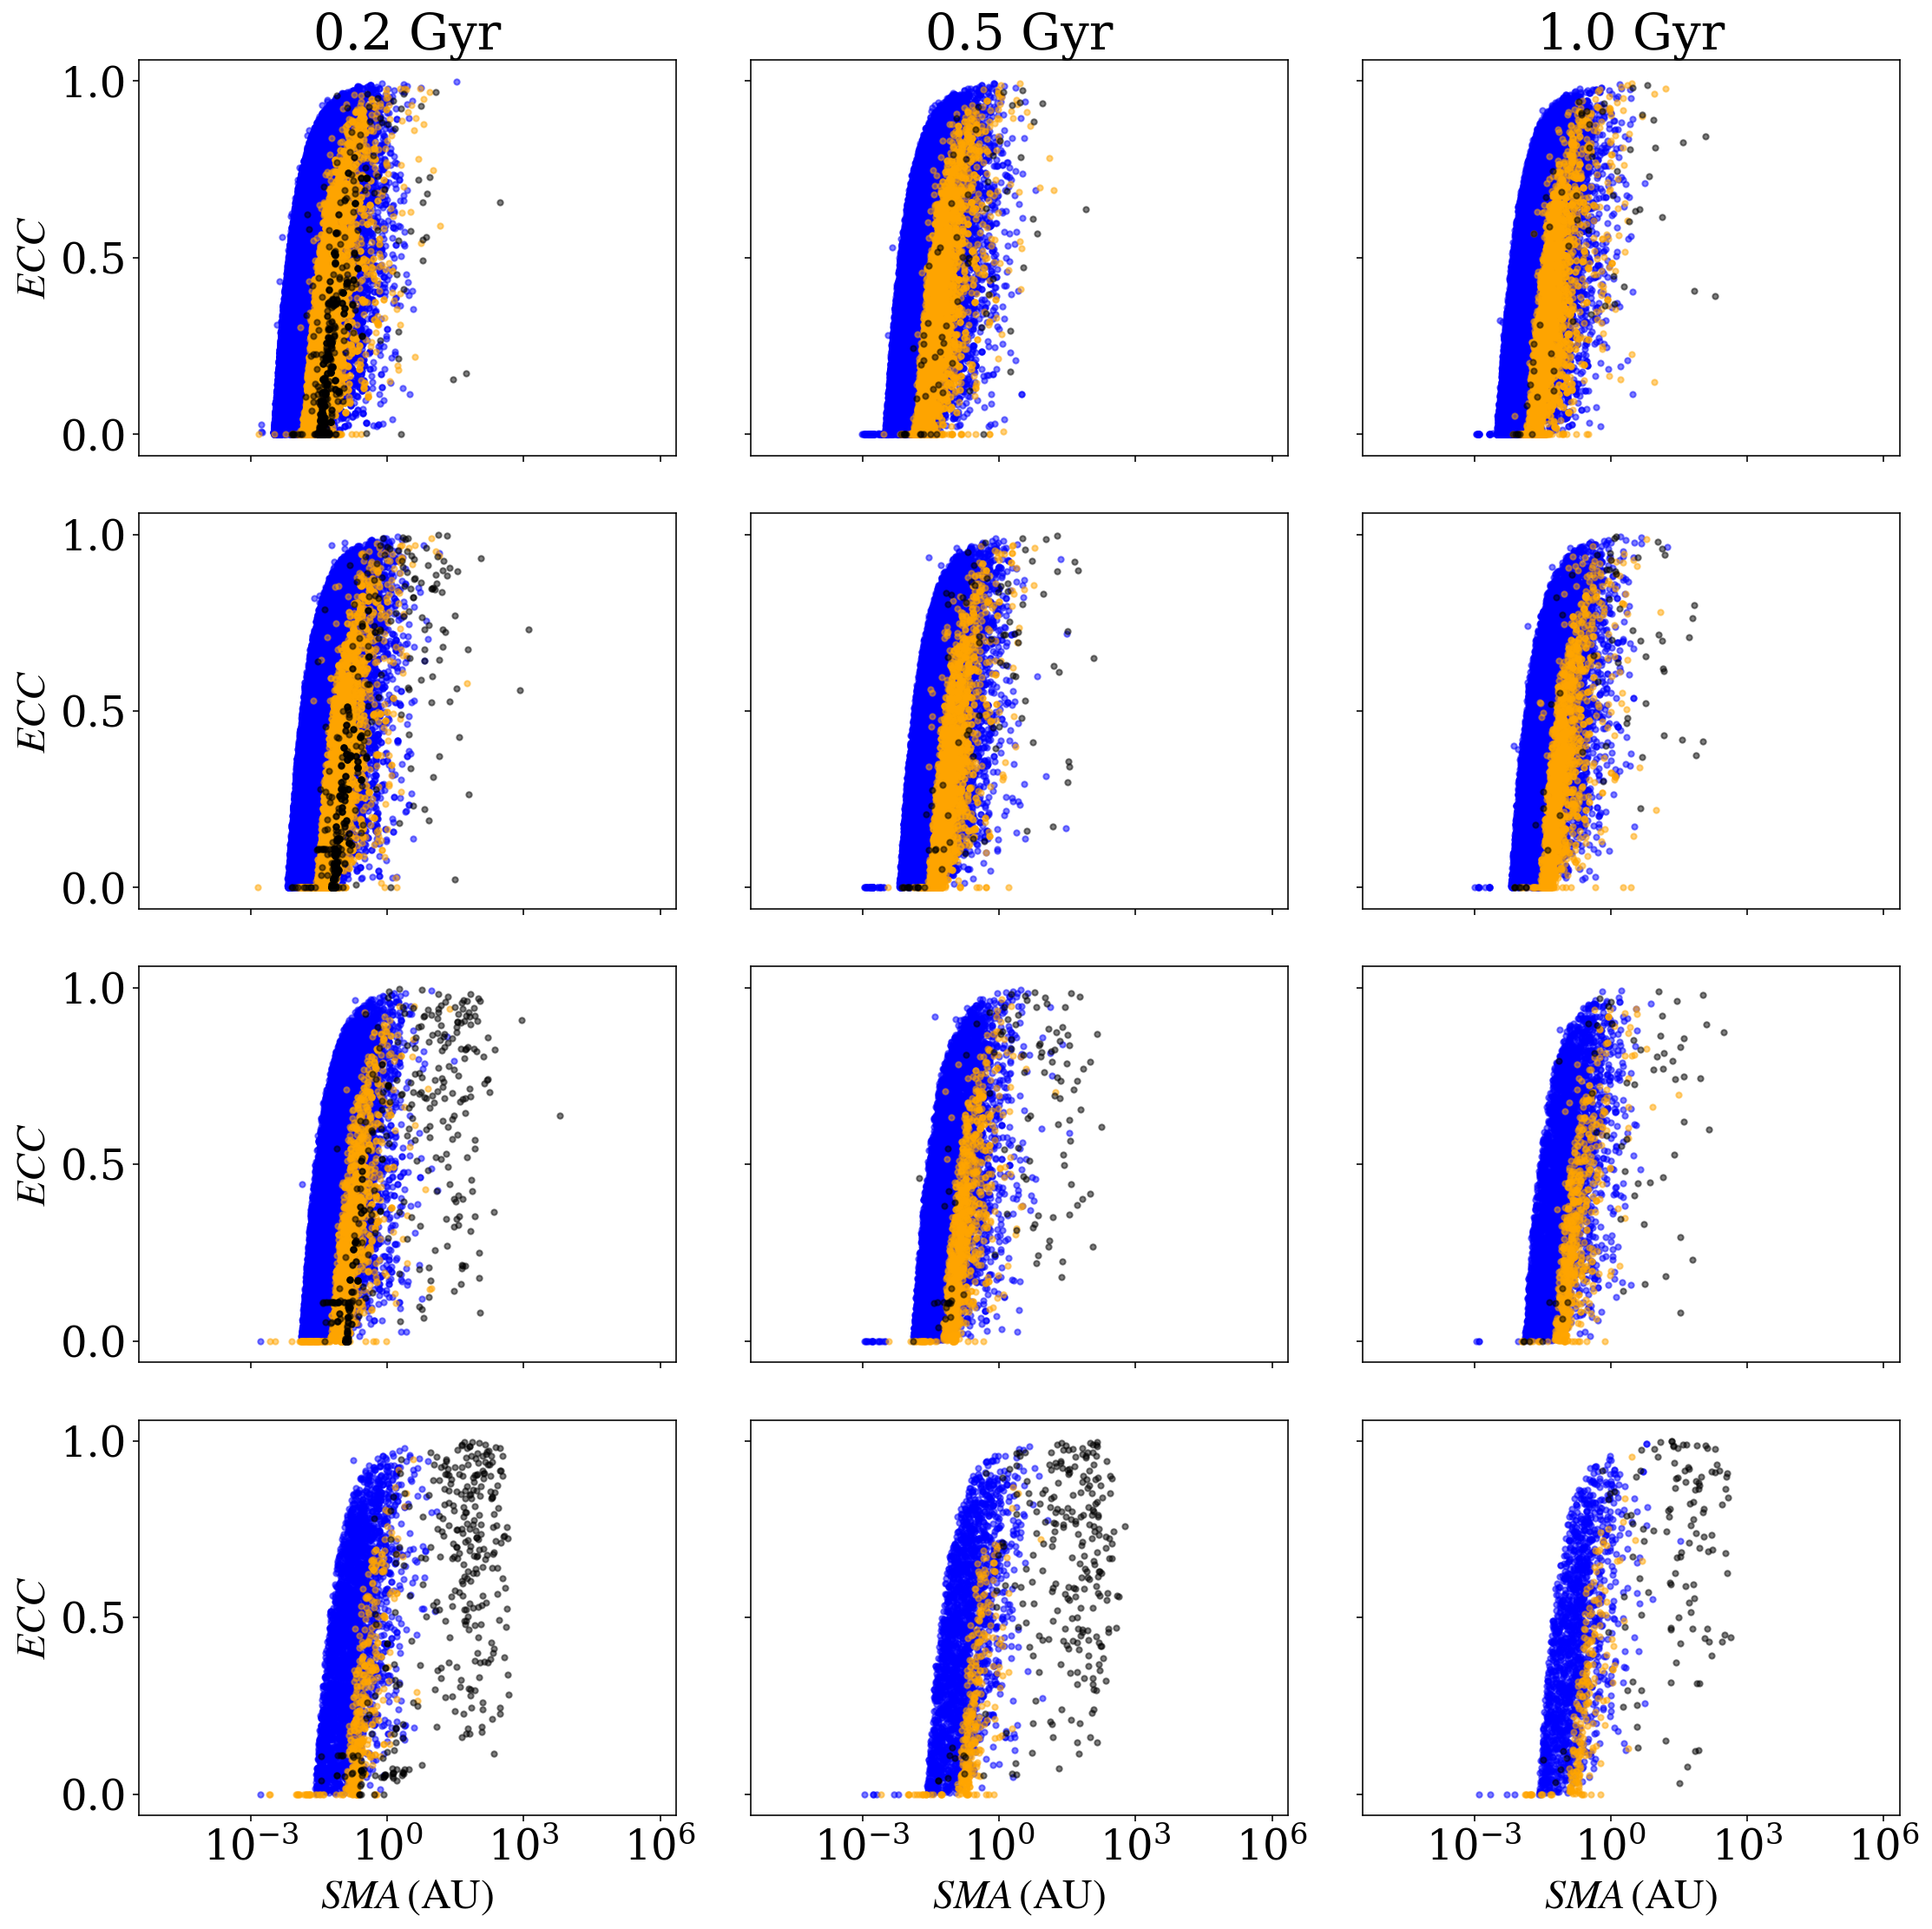

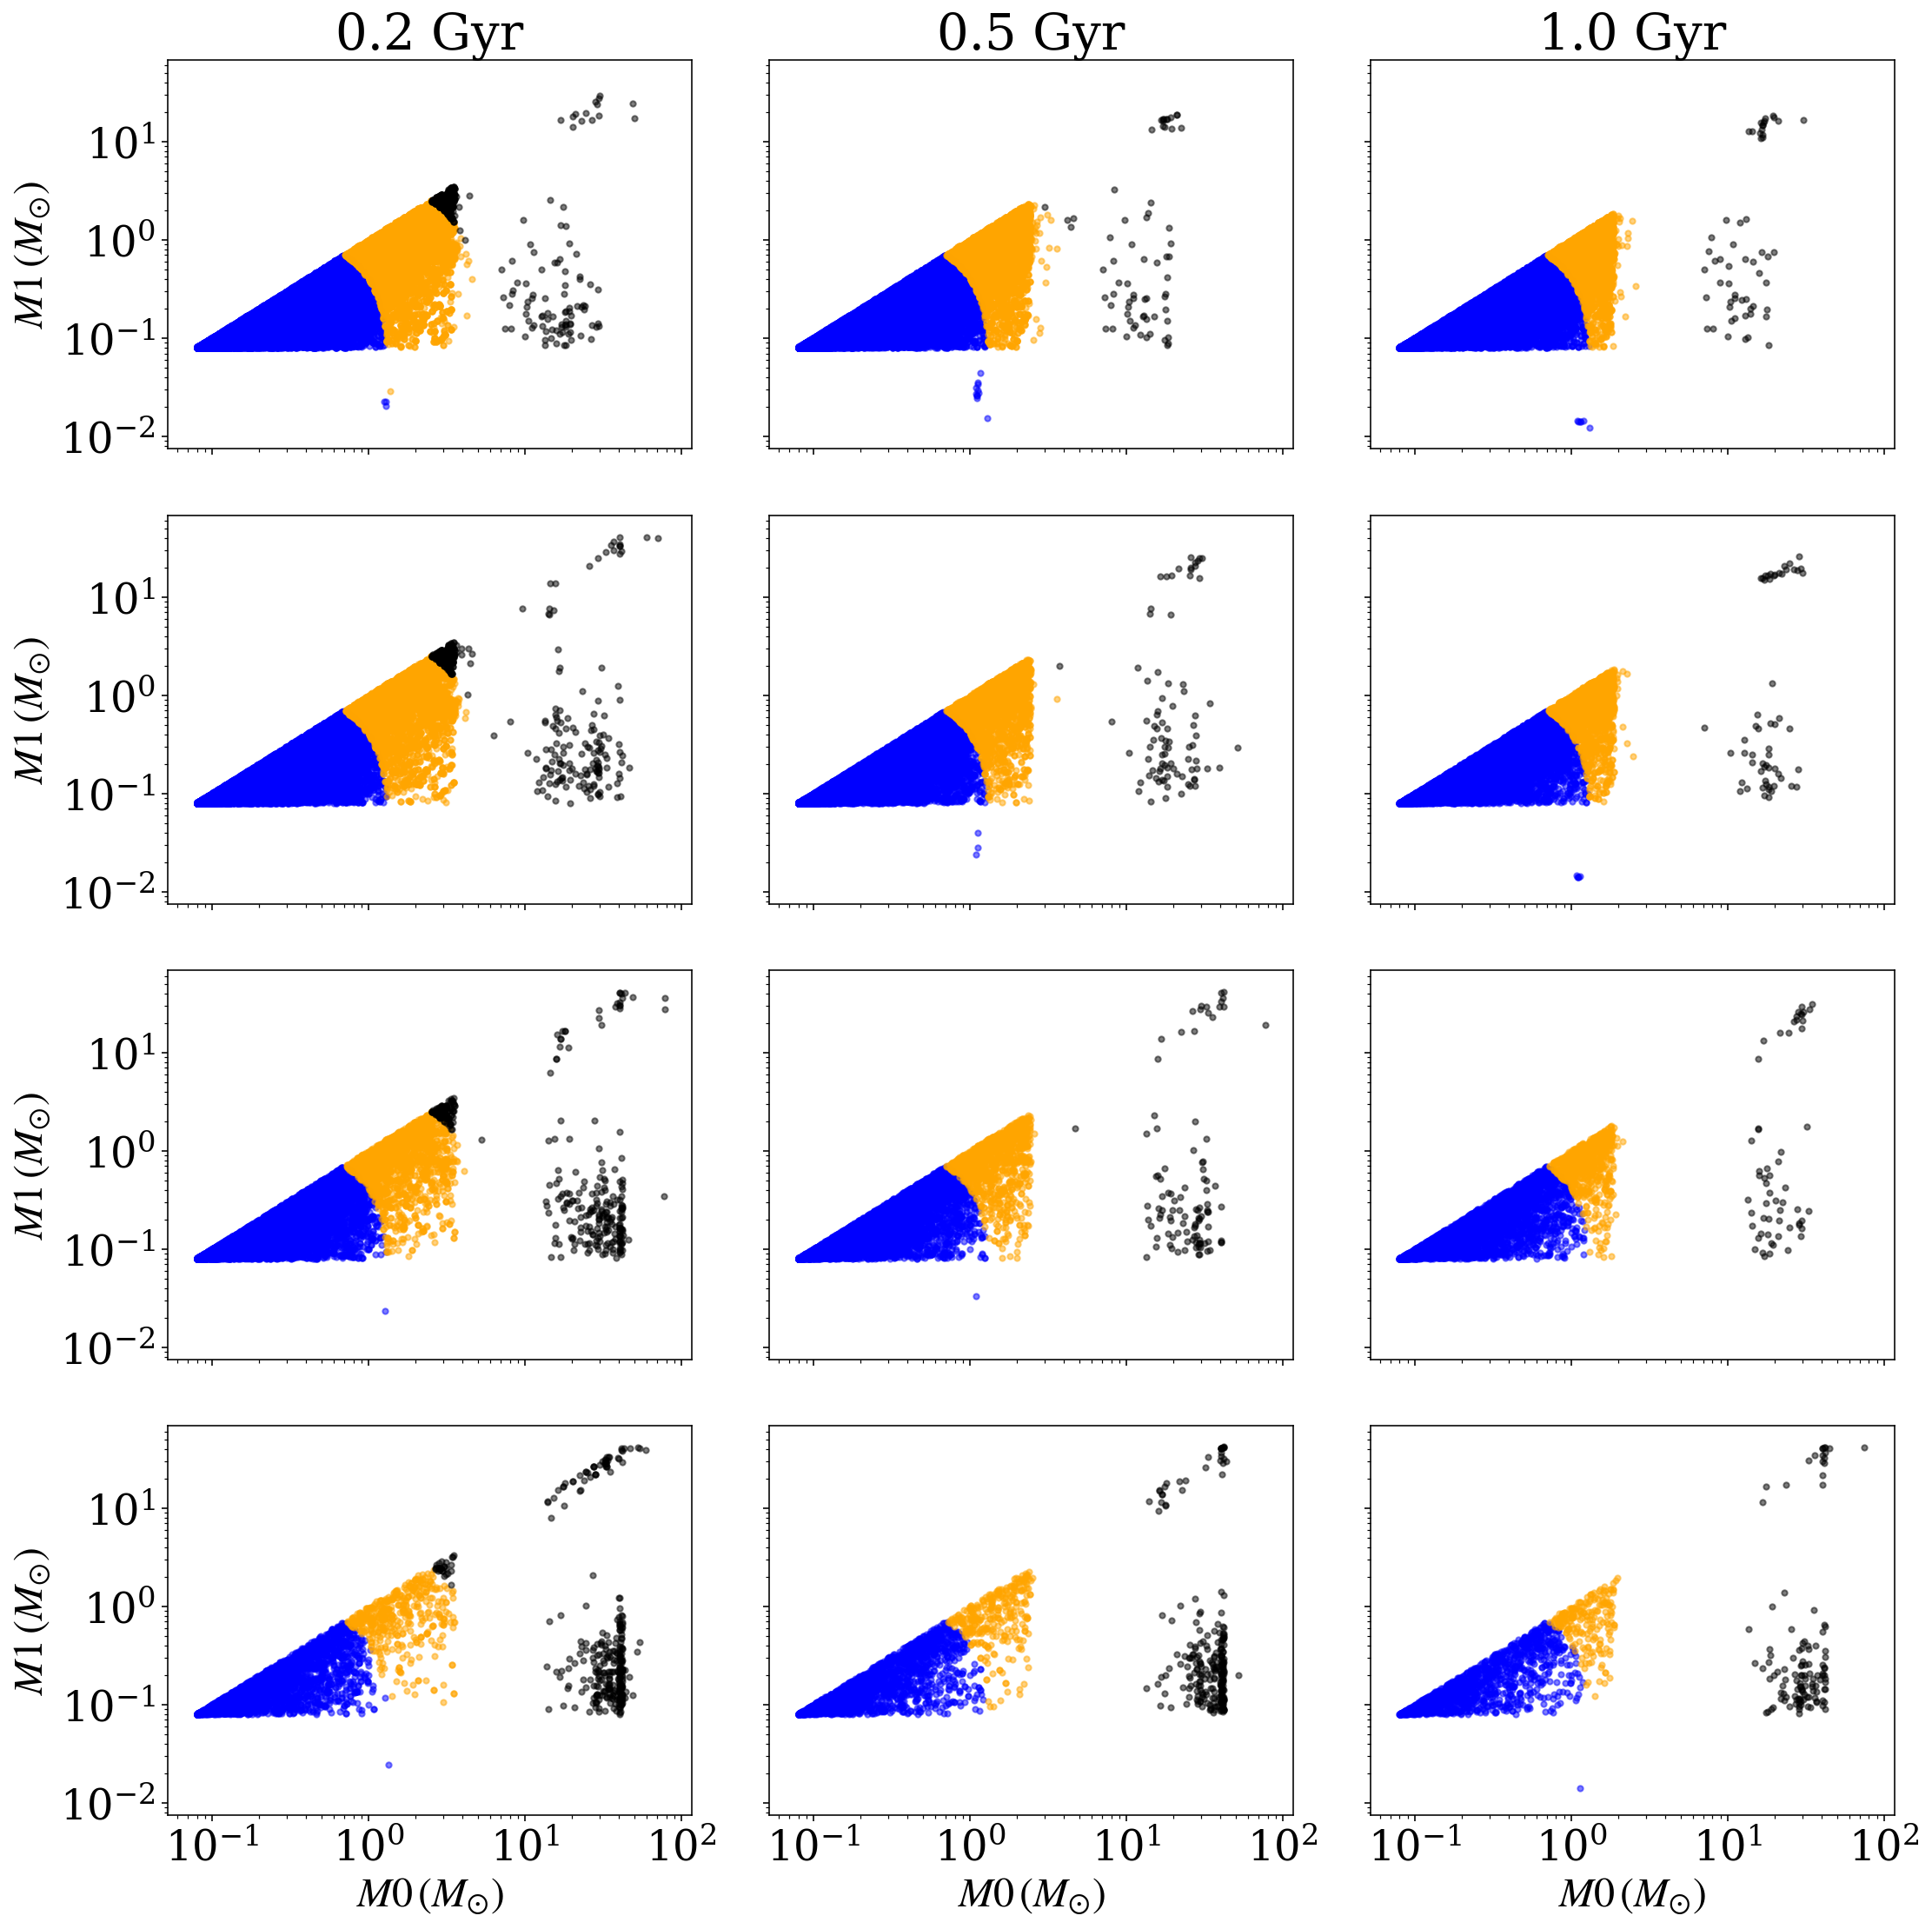

In [8]:
##binary properties for all binaries

t_step = [0.2,0.5,1.]  #Gyr
Ninit = [8e5]#, 1.6e6
m_ranges = [0.16,1.4,5.]

for zz in range(len(Ninit)):
    fig1, ax1 = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=True, figsize=(16, 16))
    fig2, ax2 = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=True, figsize=(16, 16))
    for hh in range(len(t_step)):
        M0 = [[],[],[],[]]; M1 = [[],[],[],[]]
        SMA = [[],[],[],[]]; ECC = [[],[],[],[]]
        Mtot = [[],[],[],[]]
        for xx in range(len(paths)):
            t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
            l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
            
            s=paths[xx].split('/')
            n_star=int(float(s[-2]))
            z=float(s[-3][1:])
            rg=float(s[-4][2:])
            rv=float(s[-5][2:])
            
            allsnaps=np.sort(glob(paths[xx]+'*.snap*.dat.gz'))
            snap2d=np.sort(glob(paths[xx]+'*.snap*.2Dproj.dat.gz'))
    
            index=[]
            for mm in range(len(allsnaps)):
                for nn in range(len(snap2d)):
                    if allsnaps[mm]==snap2d[nn]: index.append(mm)
    
            allsnaps = [x for y, x in enumerate(allsnaps) if y not in index]
            
            if n_star!=Ninit[zz] or z>0.002:
                continue
            
            for ii in range(len(allsnaps)):
                if os.stat(allsnaps[ii]).st_size==0:
                        continue
                if ns.get_time(allsnaps[ii])*t_conv>=t_step[hh]*1000.:
                    print(ns.get_time(allsnaps[ii])*t_conv, paths[xx])
                    thetime = ns.get_time(allsnaps[ii])*t_conv
                    with gzip.open(allsnaps[ii], 'r') as fsnap:
                        next(fsnap); next(fsnap)
                        for line in fsnap:
                            data=line.split()
                            if int(data[7])==1 and float(data[2])*l_conv<=1.:
                                if float(data[8])>=float(data[9]):
                                    M0[int(math.log2(rv/0.5))].append(float(data[8]))
                                    M1[int(math.log2(rv/0.5))].append(float(data[9]))
                                else:
                                    M0[int(math.log2(rv/0.5))].append(float(data[9]))
                                    M1[int(math.log2(rv/0.5))].append(float(data[8]))
                                    
                                SMA[int(math.log2(rv/0.5))].append(float(data[12]))
                                ECC[int(math.log2(rv/0.5))].append(float(data[13]))
                                Mtot[int(math.log2(rv/0.5))].append(float(data[1]))
                
                    break

        for jj in range(4):
            print(len(M0[jj]))
            ax1[jj][hh].scatter(np.array(SMA[jj])[(np.array(Mtot[jj])>=m_ranges[0]) & (np.array(Mtot[jj])<=m_ranges[1])], 
                                np.array(ECC[jj])[(np.array(Mtot[jj])>=m_ranges[0]) & (np.array(Mtot[jj])<=m_ranges[1])], 
                                color = 'b', alpha=0.5,s=10)
            ax1[jj][hh].scatter(np.array(SMA[jj])[(np.array(Mtot[jj])>=m_ranges[1]) & (np.array(Mtot[jj])<=m_ranges[2])], 
                                np.array(ECC[jj])[(np.array(Mtot[jj])>=m_ranges[1]) & (np.array(Mtot[jj])<=m_ranges[2])], 
                                color = 'orange', alpha=0.5,s=10)
            ax1[jj][hh].scatter(np.array(SMA[jj])[np.array(Mtot[jj])>=m_ranges[2]], 
                                np.array(ECC[jj])[np.array(Mtot[jj])>=m_ranges[2]], 
                                color = 'k', alpha=0.5,s=10)
            ax1[jj][hh].set_xscale('log')
            ax2[jj][hh].scatter(np.array(M0[jj])[(np.array(Mtot[jj])>=m_ranges[0]) & (np.array(Mtot[jj])<=m_ranges[1])], 
                                np.array(M1[jj])[(np.array(Mtot[jj])>=m_ranges[0]) & (np.array(Mtot[jj])<=m_ranges[1])], 
                                color = 'b', alpha=0.5,s=10)
            ax2[jj][hh].scatter(np.array(M0[jj])[(np.array(Mtot[jj])>=m_ranges[1]) & (np.array(Mtot[jj])<=m_ranges[2])], 
                                np.array(M1[jj])[(np.array(Mtot[jj])>=m_ranges[1]) & (np.array(Mtot[jj])<=m_ranges[2])], 
                                color = 'orange', alpha=0.5,s=10)
            ax2[jj][hh].scatter(np.array(M0[jj])[np.array(Mtot[jj])>=m_ranges[2]], 
                                np.array(M1[jj])[np.array(Mtot[jj])>=m_ranges[2]], 
                                color = 'k', alpha=0.5,s=10)
            ax2[jj][hh].set_xscale('log')
            ax2[jj][hh].set_yscale('log')
            if jj==3:
                ax1[jj][hh].set_xlabel(r'$SMA\,(\rm{AU})$')
                ax2[jj][hh].set_xlabel(r'$M0\,(M_{\odot})$')
            if jj==0:
                ax1[jj][hh].set_title(str(t_step[hh])+' Gyr')
                ax2[jj][hh].set_title(str(t_step[hh])+' Gyr')
            if hh==0:
                ax1[jj][hh].set_ylabel(r'$ECC$')
                ax2[jj][hh].set_ylabel(r'$M1\,(M_{\odot})$')
        
    plt.subplots_adjust(wspace=0.02, hspace=0.05)
    fig1.tight_layout()
    fig2.tight_layout()